health insurance dataset.

1. **Age**
- What: Age of the primary insurance beneficiary
- Type: Numeric variable
- Relevance: Age is typically a key factor in determining insurance premiums

2. **Sex**
- What: Gender of the insurance contractor
- Categories: Female, Male
- Type: Categorical variable (binary)

3. **BMI (Body Mass Index)**
- What: Measure of body weight relative to height
- Formula: weight (kg) / height² (m²)
- Healthy range: 18.5 to 24.9
- Type: Numeric variable
- Relevance: Important health indicator that can affect insurance costs

4. **Children**
- What: Number of dependents covered by the insurance
- Type: Integer variable
- Represents: Number of children/dependents on the policy

5. **Smoker**
- What: Smoking status of the beneficiary
- Type: Categorical variable (binary)
- Relevance: Major factor in determining insurance premiums due to health risks

6. **Region**
- What: Beneficiary's residential area in the US
- Categories: Northeast, Southeast, Southwest, Northwest
- Type: Categorical variable
- Relevance: Geographic location can affect insurance costs due to regional variations in healthcare costs

7. **Charges**
- What: Individual medical costs billed by health insurance
- Type: Numeric variable (likely continuous)
- Target variable: This is typically what the dataset is used to predict or analyze

This dataset is commonly used for:
- Analyzing factors that influence insurance costs
- Building predictive models for insurance pricing
- Understanding the relationship between personal characteristics and medical charges
- Studying regional variations in healthcare costs


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy import stats
import requests
import pickle
import joblib

In [2]:

# shared link
shared_link = 'https://drive.google.com/file/d/118TIGf4njURpvcPFIKKAym1-sVO18DAC/view?usp=sharing'

# Extract the file ID from the shared link
file_id = shared_link.split('/')[-2]
download_link = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the data set
response = requests.get(download_link)

# Save the Data temporarily (you can delete it later)
with open('insurance.csv', 'wb') as f:
    f.write(response.content)
data=pd.read_csv('insurance.csv')
data.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [3]:

# 1. Data Description and Information
print("Dataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Dataset Description:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.6

In [4]:

# 2. Check for null values
print("\nNull Values:")
print(data.isnull().sum())



Null Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [5]:

# 3. Data Preprocessing
# Convert categorical variables to numeric using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])


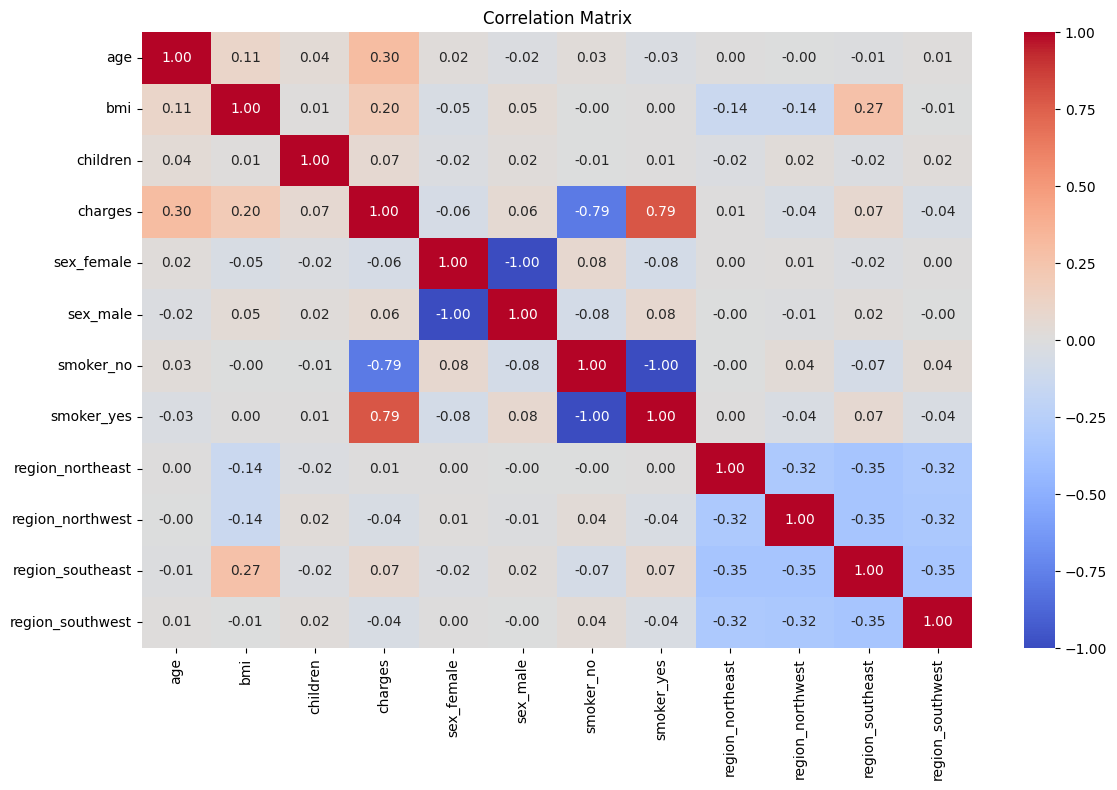

In [6]:

# 4. Correlation Analysis and Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()


In [7]:

# Separate features (X) and target variable (y)
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Feature scaling with StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale the target variable with RobustScaler
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [8]:

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 7. Elastic Net Model with GridSearchCV - Modified parameters
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [5000],  # Increased maximum iterations
    'tol': [1e-4]        # Adjusted tolerance
}

elastic_net = ElasticNet(random_state=42)
grid_search = GridSearchCV(
    elastic_net,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores
)
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# 8. Model Evaluation
y_pred_scaled = best_model.predict(X_test)
# Transform predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("\nModel Performance:")
print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")



Model Performance:
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9, 'max_iter': 5000, 'tol': 0.0001}
Mean Squared Error: 33989656.97
R2 Score: 0.78


In [9]:

# 9. Save the model and scalers
joblib.dump(best_model, 'elastic_net_model.joblib')
joblib.dump(scaler_X, 'feature_scaler.joblib')
joblib.dump(scaler_y, 'target_scaler.joblib')


['target_scaler.joblib']

In [10]:

# 10. Function to make predictions on new data
def predict_insurance_cost(new_data):
    """
    Make predictions on new data using the saved model

    Parameters:
    new_data: DataFrame with the same features as training data

    Returns:
    predicted_charges: array of predicted insurance charges
    """
    # Load saved model and scalers
    loaded_model = joblib.load('elastic_net_model.joblib')
    loaded_feature_scaler = joblib.load('feature_scaler.joblib')
    loaded_target_scaler = joblib.load('target_scaler.joblib')

    # Preprocess new data
    new_data_encoded = pd.get_dummies(new_data, columns=['sex', 'smoker', 'region'])

    # Ensure all columns from training are present
    for col in X.columns:
        if col not in new_data_encoded.columns:
            new_data_encoded[col] = 0

    # Scale the features
    new_data_scaled = loaded_feature_scaler.transform(new_data_encoded[X.columns])

    # Make predictions and transform back to original scale
    predictions_scaled = loaded_model.predict(new_data_scaled)
    predictions = loaded_target_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()

    return predictions

# Example of using the prediction function
sample_data = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [25.0],
    'children': [2],
    'smoker': ['no'],
    'region': ['southeast']
})

predicted_cost = predict_insurance_cost(sample_data)
print("\nPredicted Insurance Cost for Sample Data:")
print(f"${predicted_cost[0]:.2f}")

# Print feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(best_model.coef_)
})
print("\nFeature Importances:")
print(feature_importance.sort_values('importance', ascending=False))


Predicted Insurance Cost for Sample Data:
$4724.44

Feature Importances:
             feature  importance
5          smoker_no    0.416967
6         smoker_yes    0.375224
0                age    0.295234
1                bmi    0.160953
2           children    0.035017
7   region_northeast    0.010078
10  region_southwest    0.004407
3         sex_female    0.000000
4           sex_male    0.000000
8   region_northwest    0.000000
9   region_southeast    0.000000


# ElasticNet with PolynomialFeatures

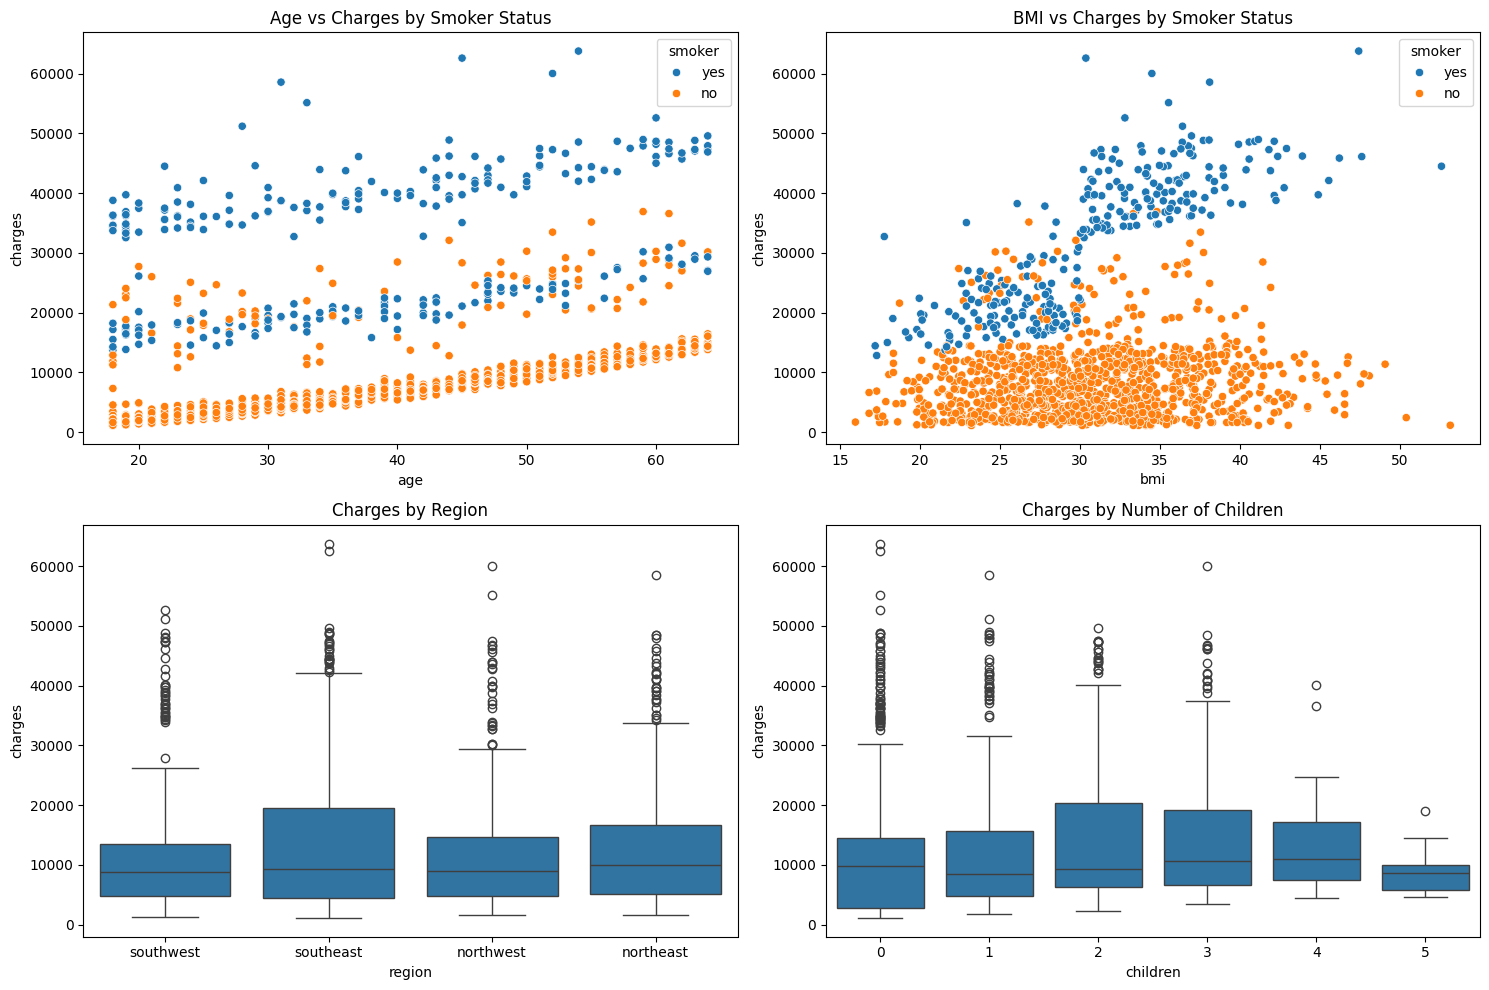

In [11]:

# 2. Preprocessing
# Convert categorical variables to numeric using one-hot encoding
categorical_columns = ['sex', 'smoker', 'region']
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# 3. Visualization of key relationships
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='age', y='charges', hue='smoker')
plt.title('Age vs Charges by Smoker Status')

plt.subplot(2, 2, 2)
sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker')
plt.title('BMI vs Charges by Smoker Status')

plt.subplot(2, 2, 3)
sns.boxplot(data=data, x='region', y='charges')
plt.title('Charges by Region')

plt.subplot(2, 2, 4)
sns.boxplot(data=data, x='children', y='charges')
plt.title('Charges by Number of Children')
plt.tight_layout()
plt.savefig('insurance_analysis.png')
plt.show()
plt.close()


In [12]:

# 4. Model Pipeline Setup
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Create pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('elastic_net', ElasticNet(random_state=42, max_iter=10000))
])


In [13]:

# 5. Enhanced Grid Search
param_grid = {
    'elastic_net__alpha': [0.0001, 0.001, 0.01, 0.1],
    'elastic_net__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'poly__degree': [1, 2]  # Try with and without polynomial features
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'r2'],
    refit='r2',
    n_jobs=-1,
    verbose=1
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
grid_search.fit(X_train, y_train)

# 6. Comprehensive Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate various metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

# 7. Cross-validation scores
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("\nCross-validation R2 scores:", cv_scores)
print(f"Mean CV R2: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")


Fitting 5 folds for each of 40 candidates, totalling 200 fits

Model Performance:
Best Parameters: {'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.5, 'poly__degree': 2}
Mean Squared Error: 20654947.94
Root Mean Squared Error: 4544.77
Mean Absolute Error: 2761.85
R2 Score: 0.87

Cross-validation R2 scores: [0.85088484 0.79608449 0.88052159 0.81784766 0.83350989]
Mean CV R2: 0.84 (+/- 0.06)


In [14]:

# 8. Save the enhanced model
joblib.dump(best_model, 'enhanced_elastic_net_model.joblib')

# 9. Improved prediction function
def predict_insurance_cost(new_data):
    """
    Make predictions on new data using the saved enhanced model

    Parameters:
    new_data: DataFrame with the same features as training data

    Returns:
    predicted_charges: array of predicted insurance charges
    confidence_interval: tuple of (lower_bound, upper_bound)
    """
    # Load saved model
    loaded_model = joblib.load('enhanced_elastic_net_model.joblib')

    # Preprocess new data
    new_data_encoded = pd.get_dummies(data, columns=categorical_columns)

    # Ensure all columns from training are present
    for col in X.columns:
        if col not in new_data_encoded.columns:
            new_data_encoded[col] = 0

    # Make prediction
    prediction = loaded_model.predict(new_data_encoded[X.columns])

    # Calculate simple confidence interval based on CV scores
    cv_std = cv_scores.std()
    confidence_interval = (
        prediction * (1 - 2 * cv_std),
        prediction * (1 + 2 * cv_std)
    )

    return prediction, confidence_interval

# Example prediction
sample_data = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [25.0],
    'children': [2],
    'smoker': ['no'],
    'region': ['southeast']
})

predicted_cost, confidence_interval = predict_insurance_cost(sample_data)
print("\nPredicted Insurance Cost for Sample Data:")
print(f"Prediction: ${predicted_cost[0]:.2f}")
print(f"95% Confidence Interval: (${confidence_interval[0][0]:.2f}, ${confidence_interval[1][0]:.2f})")



Predicted Insurance Cost for Sample Data:
Prediction: $24364.48
95% Confidence Interval: ($22963.59, $25765.37)


In [15]:

# Feature importance analysis
def get_feature_importance(model, feature_names):

    # Get the feature names after the polynomial transformation
    poly_features = model.named_steps['poly'].get_feature_names_out(feature_names)
    # Get the coefficients after the polynomial transformation
    coefficients = model.named_steps['elastic_net'].coef_
    feature_importance = pd.DataFrame({
        'feature': poly_features,  # Use poly_features instead of feature_names
        'importance': np.abs(coefficients)
    })
    return feature_importance.sort_values('importance', ascending=False)

feature_importance = get_feature_importance(best_model, X.columns)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                 feature   importance
27        bmi smoker_yes  5930.955379
26         bmi smoker_no  5930.955361
0                    age  4961.299144
62          smoker_yes^2  4229.389956
57  smoker_no smoker_yes  4229.389737
56           smoker_no^2  4229.386252
5              smoker_no  4229.383114
6             smoker_yes  4229.382199
11                 age^2  2134.043088
21  age region_southwest  1817.104473
